## Importando e Carregando Dados

In [37]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from pandas.plotting import scatter_matrix

# Carregando o dataset .arff
data = arff.loadarff('../data/car.arff')
df = pd.DataFrame(data[0])  # Convertendo para DataFrame

# Remover o prefixo b' das strings
df = df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Exibindo as primeiras linhas do DataFrame
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Análise Inicial

In [38]:
# Verificando as informações do DataFrame
print("\nInformações do DataFrame:\n")
df.info()

print("\n")

# Resumo estatístico
df_detalhes = df.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Informações do DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB



Estatísticas do DataFrame:


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


## Pré-Processamento

### Eliminação de Atributos Irrelevantes

Felizmente o dataset não possui atributos irrelevantes, mas um exemplo de como poderiamos tratá-lo caso houvese seria: 

```python
# remove as colunas user_id e original_city
df = df.drop(columns=['user_id','original_city'])

# imprime o dataframe
display(df.head(n=10))
```

### Tratamento de Atributos com Valores Ausentes

Felizmente não há campos nulos em nosso dataset.

In [44]:
# índices das linhas que contém valores NaN
idxRowNan = pd.isnull(df).any(axis=1).to_numpy().nonzero()

# imprime apenas as linhas com valoes ausentes
display(df.iloc[idxRowNan])

,buying,maint,doors,persons,lug_boot,safety,class


In [45]:
def trataFaltantes(df):
    '''
    Normalmente substituiria os valores faltantes pela média dos outros valores do mesmo atributo de amostras que 
    fosse da mesma classe, mas como como os seus dados dessa base são categóricos, será substituido os valores 
    faltantes pela moda dos outros valores do mesmo atributo de amostras que sejam da mesma classe.
    '''
    
    # Cria um dicionário para armazenar as modas de cada classe para cada coluna
    modas = {}
    
    # Para cada coluna, calcula a moda de cada classe
    for column in df.columns:
        modas[column] = df.groupby('class')[column].agg(lambda x: x.mode()[0])

    # Verifica se há valores nulos em cada coluna e substitui
    for column in df.columns:
        if df[column].isnull().any():
            # Substitui os valores nulos pela moda correspondente à classe
            df[column].fillna(modas[column][df['class']], inplace=True)

    return df

# Supondo que você tivesse valores nulos em meu DataFrame, chamariamos a função
df = trataFaltantes(df)

# Para verificar quais linhas continham valores nulos antes da substituição, executariamos:
idxRowNan = df[df.isnull().any(axis=1)].index
print('\nAmostras que tinham valores faltantes:')
display(df.iloc[idxRowNan])


Amostras que tinham valores faltantes:


,buying,maint,doors,persons,lug_boot,safety,class


### Tratamento de Dados Inconsistentes ou Redundantes

Felizmente não há valores redundantes ou inconsistentes em nosso dataset.

In [47]:
def delDuplicatas(df):
    '''
    Para cada grupo de amostras duplicadas, mantém uma e apaga as demais.
    '''
    df = df.drop_duplicates(keep='first')
    return df

# Detectar duplicatas
df_duplicates = df[df.duplicated(keep=False)]

# Se houver valores redundantes, imprima
if len(df_duplicates) > 0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')

# Remover duplicatas
df = delDuplicatas(df)
print("\nDataFrame após remoção de duplicatas:")
display(df)

Não existem valores duplicados

DataFrame após remoção de duplicatas:


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [48]:
# Para detectar inconsistências
def delInconsistencias(df):
    '''
    Remove todas as amostras inconsistentes da base de dados.
    '''
    df = df.drop_duplicates(subset=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], keep=False)
    return df

# Obtém as amostras onde os valores dos atributos estão duplicados
df_duplicates_inconsistentes = df[df.duplicated(subset=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], keep=False)]

# Se houver inconsistências, imprima
if len(df_duplicates_inconsistentes) > 0:
    print('\nAmostras inconsistentes:')
    display(df_duplicates_inconsistentes)
else:
    print('Não existem amostras inconsistentes')

# Remover inconsistências
df = delInconsistencias(df)
print("\nDataFrame após remoção de inconsistências:")
display(df)

Não existem amostras inconsistentes

DataFrame após remoção de inconsistências:


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [49]:
# Vamos revisar as principais estatísticas da base de dados
df_detalhes = df.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Estatísticas do DataFrame:


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


### Normalização dos Atributos

A normalização é útil quando você tem atributos numéricos contínuos que podem variar amplamente. Essa técnica é utilizada para trazer esses dados para uma escala semelhante, mas como estamos lidando principalmente com atributos categóricos, a representação binária (0 e 1) faz mais sentido. Essa abordagem captura a presença ou ausência de características de forma clara e é apropriada para a análise e a modelagem.

Mesmo que tenhamos atributos como "número de portas" ou "número de passageiros", representá-los como categorias pode ser mais adequado no contexto de nosso dataset, especialmente por eles não serem contínuos.

Por isso utilizaremos o **one-hot encoding**, uma técnica aplicada a dados categóricos para transformar cada categoria em uma nova coluna binária, onde ``1`` indica a presença da categoria e ``0`` a ausência.

In [39]:
# Aplicando one-hot encoding
df_encoded = pd.get_dummies(df, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], drop_first=False)

# Convertendo valores booleanos para inteiros
numeric_columns = df_encoded.select_dtypes(include=[bool]).columns  # Seleciona colunas booleanas
df_encoded[numeric_columns] = df_encoded[numeric_columns].astype(int)  # Converte para inteiros

print(df_encoded.head())


   class  buying_high  buying_low  buying_med  buying_vhigh  maint_high  \
0  unacc            0           0           0             1           0   
1  unacc            0           0           0             1           0   
2  unacc            0           0           0             1           0   
3  unacc            0           0           0             1           0   
4  unacc            0           0           0             1           0   

   maint_low  maint_med  maint_vhigh  doors_2  ...  doors_5more  persons_2  \
0          0          0            1        1  ...            0          1   
1          0          0            1        1  ...            0          1   
2          0          0            1        1  ...            0          1   
3          0          0            1        1  ...            0          1   
4          0          0            1        1  ...            0          1   

   persons_4  persons_more  lug_boot_big  lug_boot_med  lug_boot_small  \
0     

Em outro contexto, se fosse necessário normalizar atributos em valores numéricos. poderiamos por exemplo o seguinte script:

```python
def normalizar(X):
    m, n = X.shape  # m = qtde de objetos e n = qtde de atributos por objeto
    X_norm = np.zeros((m, n))  # inicializa X_norm com zeros
    mu = np.mean(X, axis=0)  # calcula a média
    sigma = np.std(X, axis=0, ddof=1)  # calcula o desvio padrão

    for i in range(m):
        X_norm[i, :] = (X[i, :] - mu) / sigma

    return X_norm, mu, sigma

# Identificando colunas numéricas
numeric_columns = df_encoded.select_dtypes(include=[np.number]).columns.tolist()  # Seleciona colunas numéricas
X = df_encoded[numeric_columns].values  # Seleciona os valores para normalização

# Chama a função para normalizar X
X_norm, mu, sigma = normalizar(X)

# Atualiza o DataFrame com os valores normalizados
df_encoded[numeric_columns] = X_norm
```

In [40]:
# Verificando as informações do DataFrame
print("\nInformações do DataFrame:\n")
df_encoded.info()

print("\n")

# Resumo estatístico
df_detalhes = df_encoded.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Informações do DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           1728 non-null   object
 1   buying_high     1728 non-null   int64 
 2   buying_low      1728 non-null   int64 
 3   buying_med      1728 non-null   int64 
 4   buying_vhigh    1728 non-null   int64 
 5   maint_high      1728 non-null   int64 
 6   maint_low       1728 non-null   int64 
 7   maint_med       1728 non-null   int64 
 8   maint_vhigh     1728 non-null   int64 
 9   doors_2         1728 non-null   int64 
 10  doors_3         1728 non-null   int64 
 11  doors_4         1728 non-null   int64 
 12  doors_5more     1728 non-null   int64 
 13  persons_2       1728 non-null   int64 
 14  persons_4       1728 non-null   int64 
 15  persons_more    1728 non-null   int64 
 16  lug_boot_big    1728 non-null   int64 
 17  lug_boot_med    1728 non

,class,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
count,1728,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,...,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,unacc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
std,NaN,0.433138,0.433138,0.433138,0.433138,0.433138,0.433138,0.433138,0.433138,0.433138,...,0.433138,0.471541,0.471541,0.471541,0.471541,0.471541,0.471541,0.471541,0.471541,0.471541
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Detecção de *Outliers*

Se algum atributo tiver uma proporção extremamente desequilibrada, pode ser um indicativo de outliers.

Por exemplo, se um atributo tem 90% de 0s e 10% de 1s, e você espera um balanceamento mais próximo de 50/50, isso pode ser considerado anômalo.

In [41]:
# Verificando a distribuição de valores 0 e 1
for column in df_encoded.columns:
    print(f"{column}:\n{df_encoded[column].value_counts(normalize=True)}\n")

class:
class
unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: proportion, dtype: float64

buying_high:
buying_high
0    0.75
1    0.25
Name: proportion, dtype: float64

buying_low:
buying_low
0    0.75
1    0.25
Name: proportion, dtype: float64

buying_med:
buying_med
0    0.75
1    0.25
Name: proportion, dtype: float64

buying_vhigh:
buying_vhigh
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_high:
maint_high
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_low:
maint_low
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_med:
maint_med
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_vhigh:
maint_vhigh
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_2:
doors_2
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_3:
doors_3
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_4:
doors_4
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_5more:
doors_5more
0    0.75
1    0.25
Nam

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

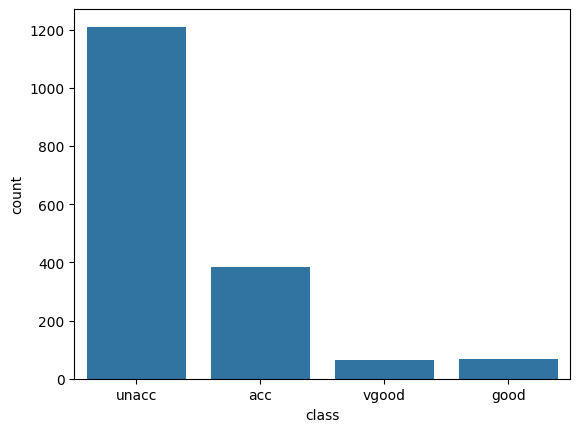

In [42]:
# Distribuição das classes
display(df_encoded['class'].value_counts())

# cria um gráfico de barras com a frequência de cada classe
sns.countplot(x="class", data=df_encoded)

# mostra o gráfico
plt.show()

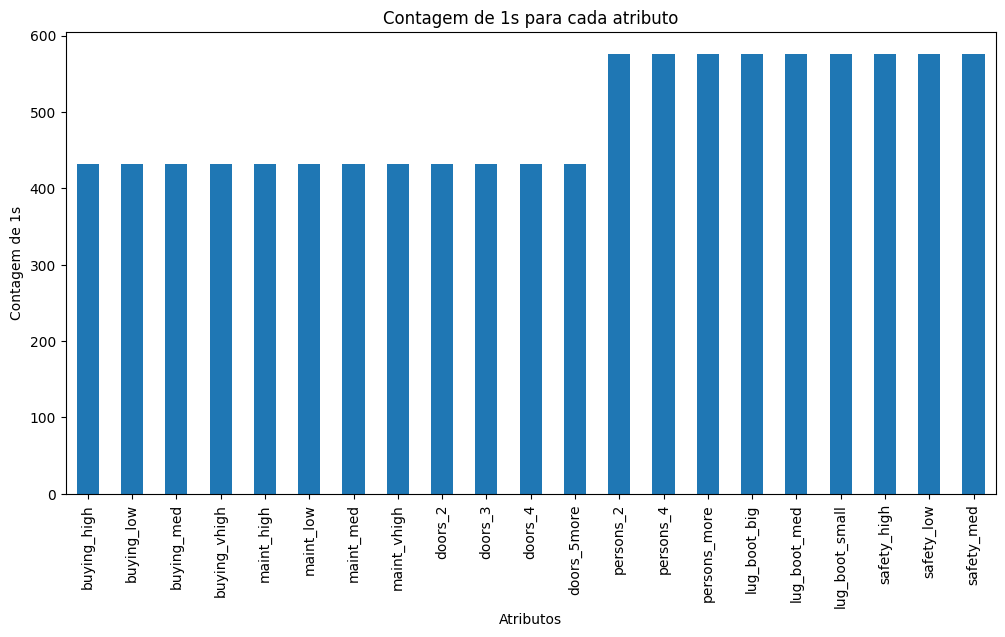

In [43]:
# Visualização em gráfico da distribuição
df_encoded.drop(columns=['class']).sum().plot(kind='bar', figsize=(12, 6))
plt.title('Contagem de 1s para cada atributo')
plt.xlabel('Atributos')
plt.ylabel('Contagem de 1s')
plt.show()

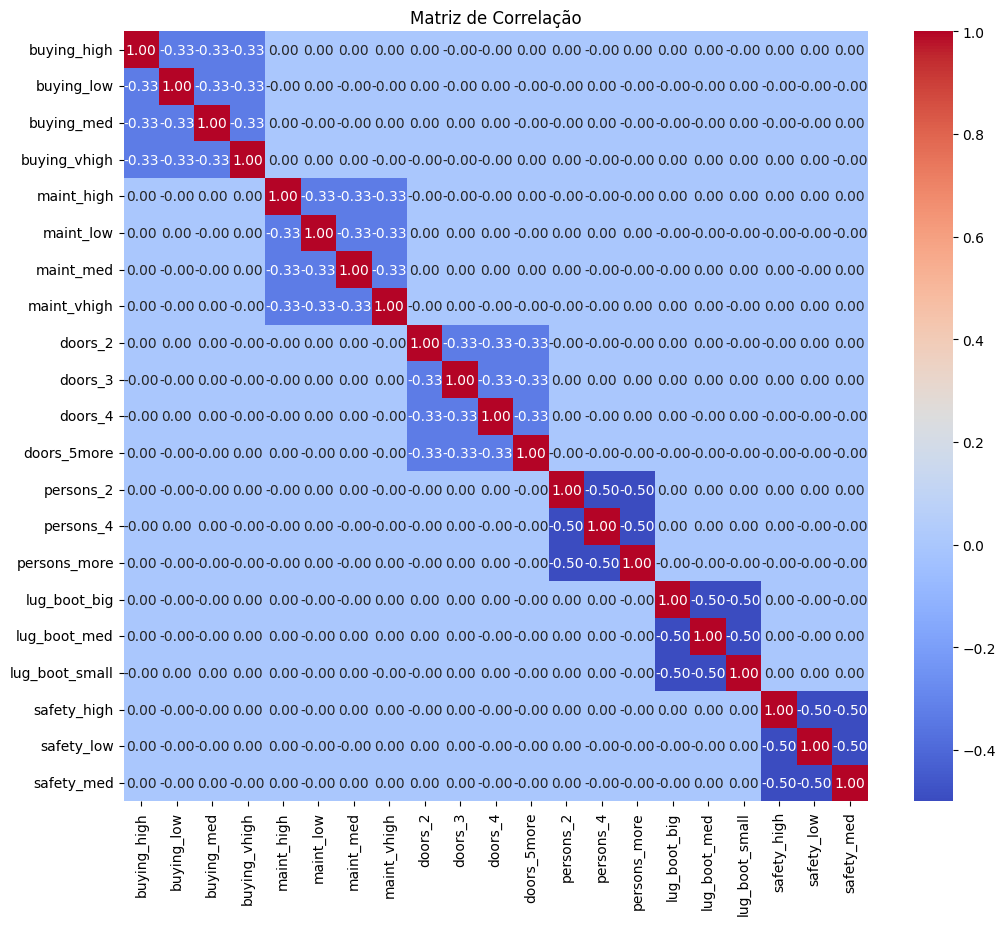

In [44]:
# Remover a coluna de classes
df_numeric = df_encoded.drop(columns=['class'])

# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


Importância dos Atributos:

1. Atributo safety_low: 0.1398630600686636
2. Atributo persons_2: 0.128792092797346
3. Atributo safety_high: 0.06973666843684077
4. Atributo maint_vhigh: 0.053353170483766706
5. Atributo persons_4: 0.05317667243505996
6. Atributo persons_more: 0.05258948299041883
7. Atributo buying_low: 0.051049744968263616
8. Atributo buying_vhigh: 0.04737750757341713
9. Atributo safety_med: 0.04623560535626323
10. Atributo lug_boot_small: 0.04516451949175838
11. Atributo buying_high: 0.03955088920198748
12. Atributo maint_low: 0.03939421307825139
13. Atributo buying_med: 0.03766322431333015
14. Atributo maint_high: 0.03730827760838684
15. Atributo maint_med: 0.033141900807473236
16. Atributo lug_boot_big: 0.03301560486615401
17. Atributo doors_2: 0.028611631312446775
18. Atributo lug_boot_med: 0.02165264747938037
19. Atributo doors_5more: 0.01432030766209412
20. Atributo doors_3: 0.01427946117181121
21. Atributo doors_4: 0.013723317896886229

***



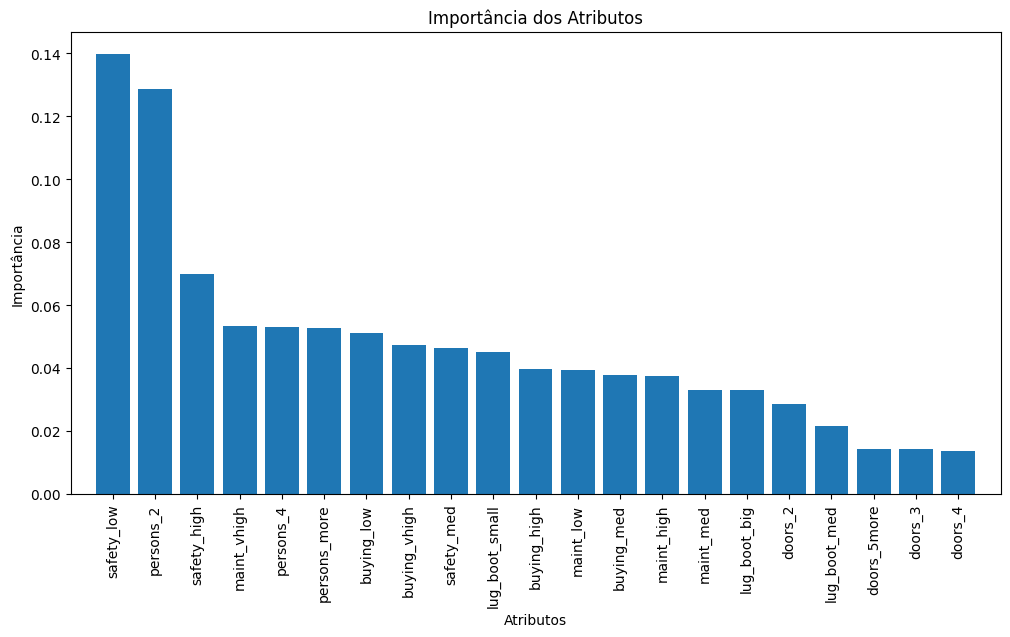

In [45]:
# Define a importância dos atributos
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

model = RandomForestClassifier()
model.fit(X, y)

# Ordena as importâncias dos atributos
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nImportância dos Atributos:\n")

# Imprime a importância dos atributos
for f in range(X.shape[1]):
    print(f"{f + 1}. Atributo {X.columns[indices[f]]}: {importances[indices[f]]}")

print("\n***\n")

# Configura o gráfico
plt.figure(figsize=(12, 6))
plt.title("Importância dos Atributos")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)  # Rótulos dos atributos
plt.xlim([-1, X.shape[1]])
plt.xlabel("Atributos")
plt.ylabel("Importância")
plt.show()



#### Análise das Proporções

##### **Proporção das Classes**

A distribuição das classes apresenta a seguinte configuração:

- **Inaceitável (unacc)**: 70.02%
- **Aceitável (acc)**: 22.22%
- **Bom (good)**: 3.99%
- **Muito Bom (vgood)**: 3.76%

A classe "**Inaceitável**" é claramente a mais prevalente, o que sugere um desequilíbrio significativo no dataset. Esse desequilíbrio pode afetar o desempenho do modelo, tornando-o tendencioso em favor da classe majoritária. Medidas de balanceamento, como SMOTE e undersampling, são essenciais para mitigar esse problema e melhorar a generalização do modelo.

##### **Proporções dos Atributos Categóricos**

A análise das proporções dos atributos indica que a maioria das características (compras, manutenção, portas, capacidade, tamanho do porta-malas e segurança) apresenta uma distribuição relativamente uniforme entre seus valores. Por exemplo:

- Atributo "buying":

    - "High" (1) representa 25% dos dados, enquanto "Low", "Medium" e "Very High" também têm 25% cada.

- Atributo "maint":

    - A mesma distribuição se repete para "maint", indicando que as escolhas de manutenção não influenciam significativamente a classe.

- Atributo "doors":

    - A distribuição entre os atributos de portas é igualmente uniforme, com cada valor contribuindo de forma semelhante para o total.

- Atributos de Capacidade e Tamanho do Porta-Malas:

    - A proporção de "persons" e "lug_boot" mostra uma leve tendência em direção a valores mais baixos, mas ainda mantém uma distribuição balanceada.

- Atributo "safety":

    - A segurança é um fator crítico, e a distribuição mostra que os atributos de segurança também seguem um padrão semelhante.

Porém, com relação a importância dos atributos, podemos notar que a preferencia está em uma segurança baixa e na capacidade de duas pessoas.

#### Considerações Finais

A predominância da classe "Inaceitável" destaca a importância de aplicar técnicas de balanceamento. Além disso, as distribuições uniformes entre os atributos sugerem que eles podem contribuir igualmente para a predição. Essa informação pode ser utilizada para ajustar as abordagens de modelagem, otimizando a seleção de características e as estratégias de amostragem.

Apesar de utilizarmos técnicas para uma uniformização leve dos dados de atributos, nosso foco será na mitigação da discrepancia entre as classes.

In [46]:
# Oversampling

# Separando características e classes
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

# Aplicando SMOTE para aumentar a classe minoritária
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Mostra a nova distribuição das classes
print(y_resampled.value_counts())

class
unacc    1210
acc      1210
vgood    1210
good     1210
Name: count, dtype: int64


In [47]:
# Undersampling

# Aplicando RandomUnderSampler para reduzir a classe majoritária
undersample = RandomUnderSampler(random_state=42)
X_under, y_under = undersample.fit_resample(X, y)

# Mostra a nova distribuição das classes
print(y_under.value_counts())

class
acc      65
good     65
unacc    65
vgood    65
Name: count, dtype: int64


In [51]:
# Remoção de Outliers após oversampling e undersampling

# Remoção de outliers com base em limite de 80% dos dados
threshold_resampled = 0.8 * len(X_resampled)
threshold_under = 0.8 * len(X_under)

# Seleciona apenas as colunas numéricas para a soma
numeric_columns_resampled = X_resampled.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns_under = X_under.select_dtypes(include=[np.number]).columns.tolist()

# Cria uma série booleana indicando quais colunas têm soma menor ou igual ao threshold
valid_columns_resampled = (X_resampled[numeric_columns_resampled].sum() <= threshold_resampled)
valid_columns_under = (X_under[numeric_columns_under].sum() <= threshold_under)

# Filtra o DataFrame para manter apenas as colunas válidas
df_cleaned_resampled = pd.DataFrame(X_resampled.loc[:, valid_columns_resampled[valid_columns_resampled].index])
df_cleaned_resampled['class'] = y_resampled

df_cleaned_under = pd.DataFrame(X_under.loc[:, valid_columns_under[valid_columns_under].index])
df_cleaned_under['class'] = y_under

# Combina os dois datasets limpos em um único DataFrame
df_cleaned = pd.concat([df_cleaned_resampled, df_cleaned_under], ignore_index=True)

# Mostra a forma da nova base de dados
print(df_cleaned.shape)

(5100, 22)


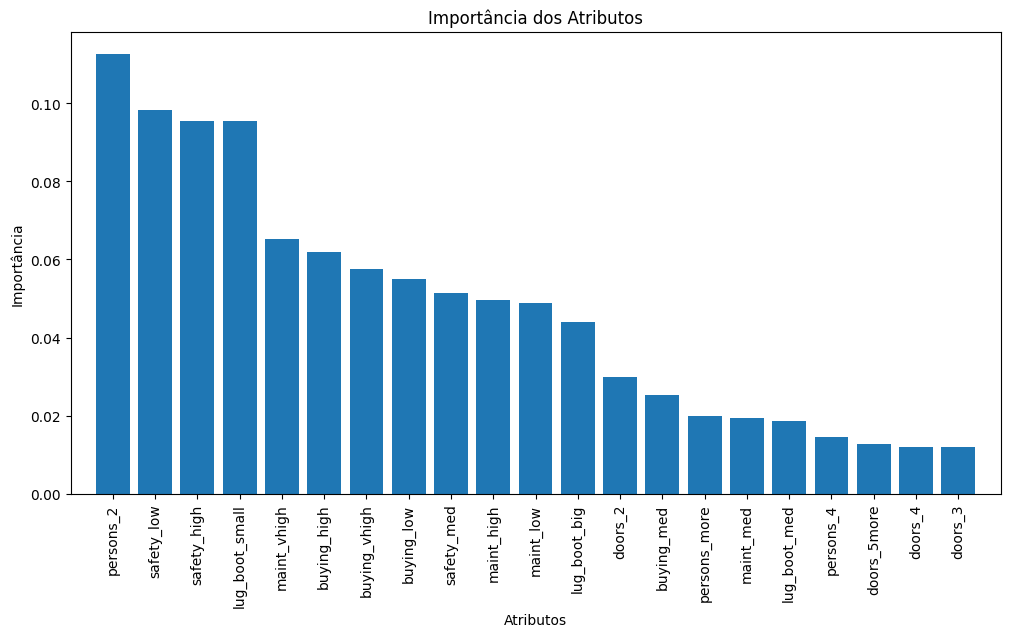

In [52]:
# Visualizando Novamente a Importâncias dos Atributos

X = df_cleaned.drop('class', axis=1)
y = df_cleaned['class']

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importância dos Atributos")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel("Atributos")
plt.ylabel("Importância")
plt.show()

class
unacc    1275
acc      1275
vgood    1275
good     1275
Name: count, dtype: int64

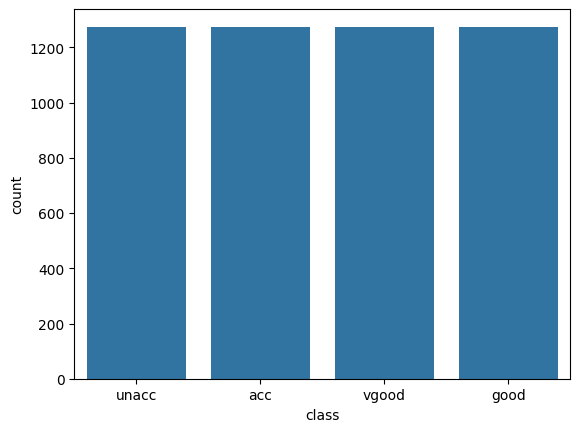

In [53]:
# Visualizando novamente a distribuição das classes

display(df_cleaned['class'].value_counts())

# cria um gráfico de barras com a frequência de cada classe
sns.countplot(x="class", data=df_cleaned)

# mostra o gráfico
plt.show()

## Visualização de Dados

### Histogramas

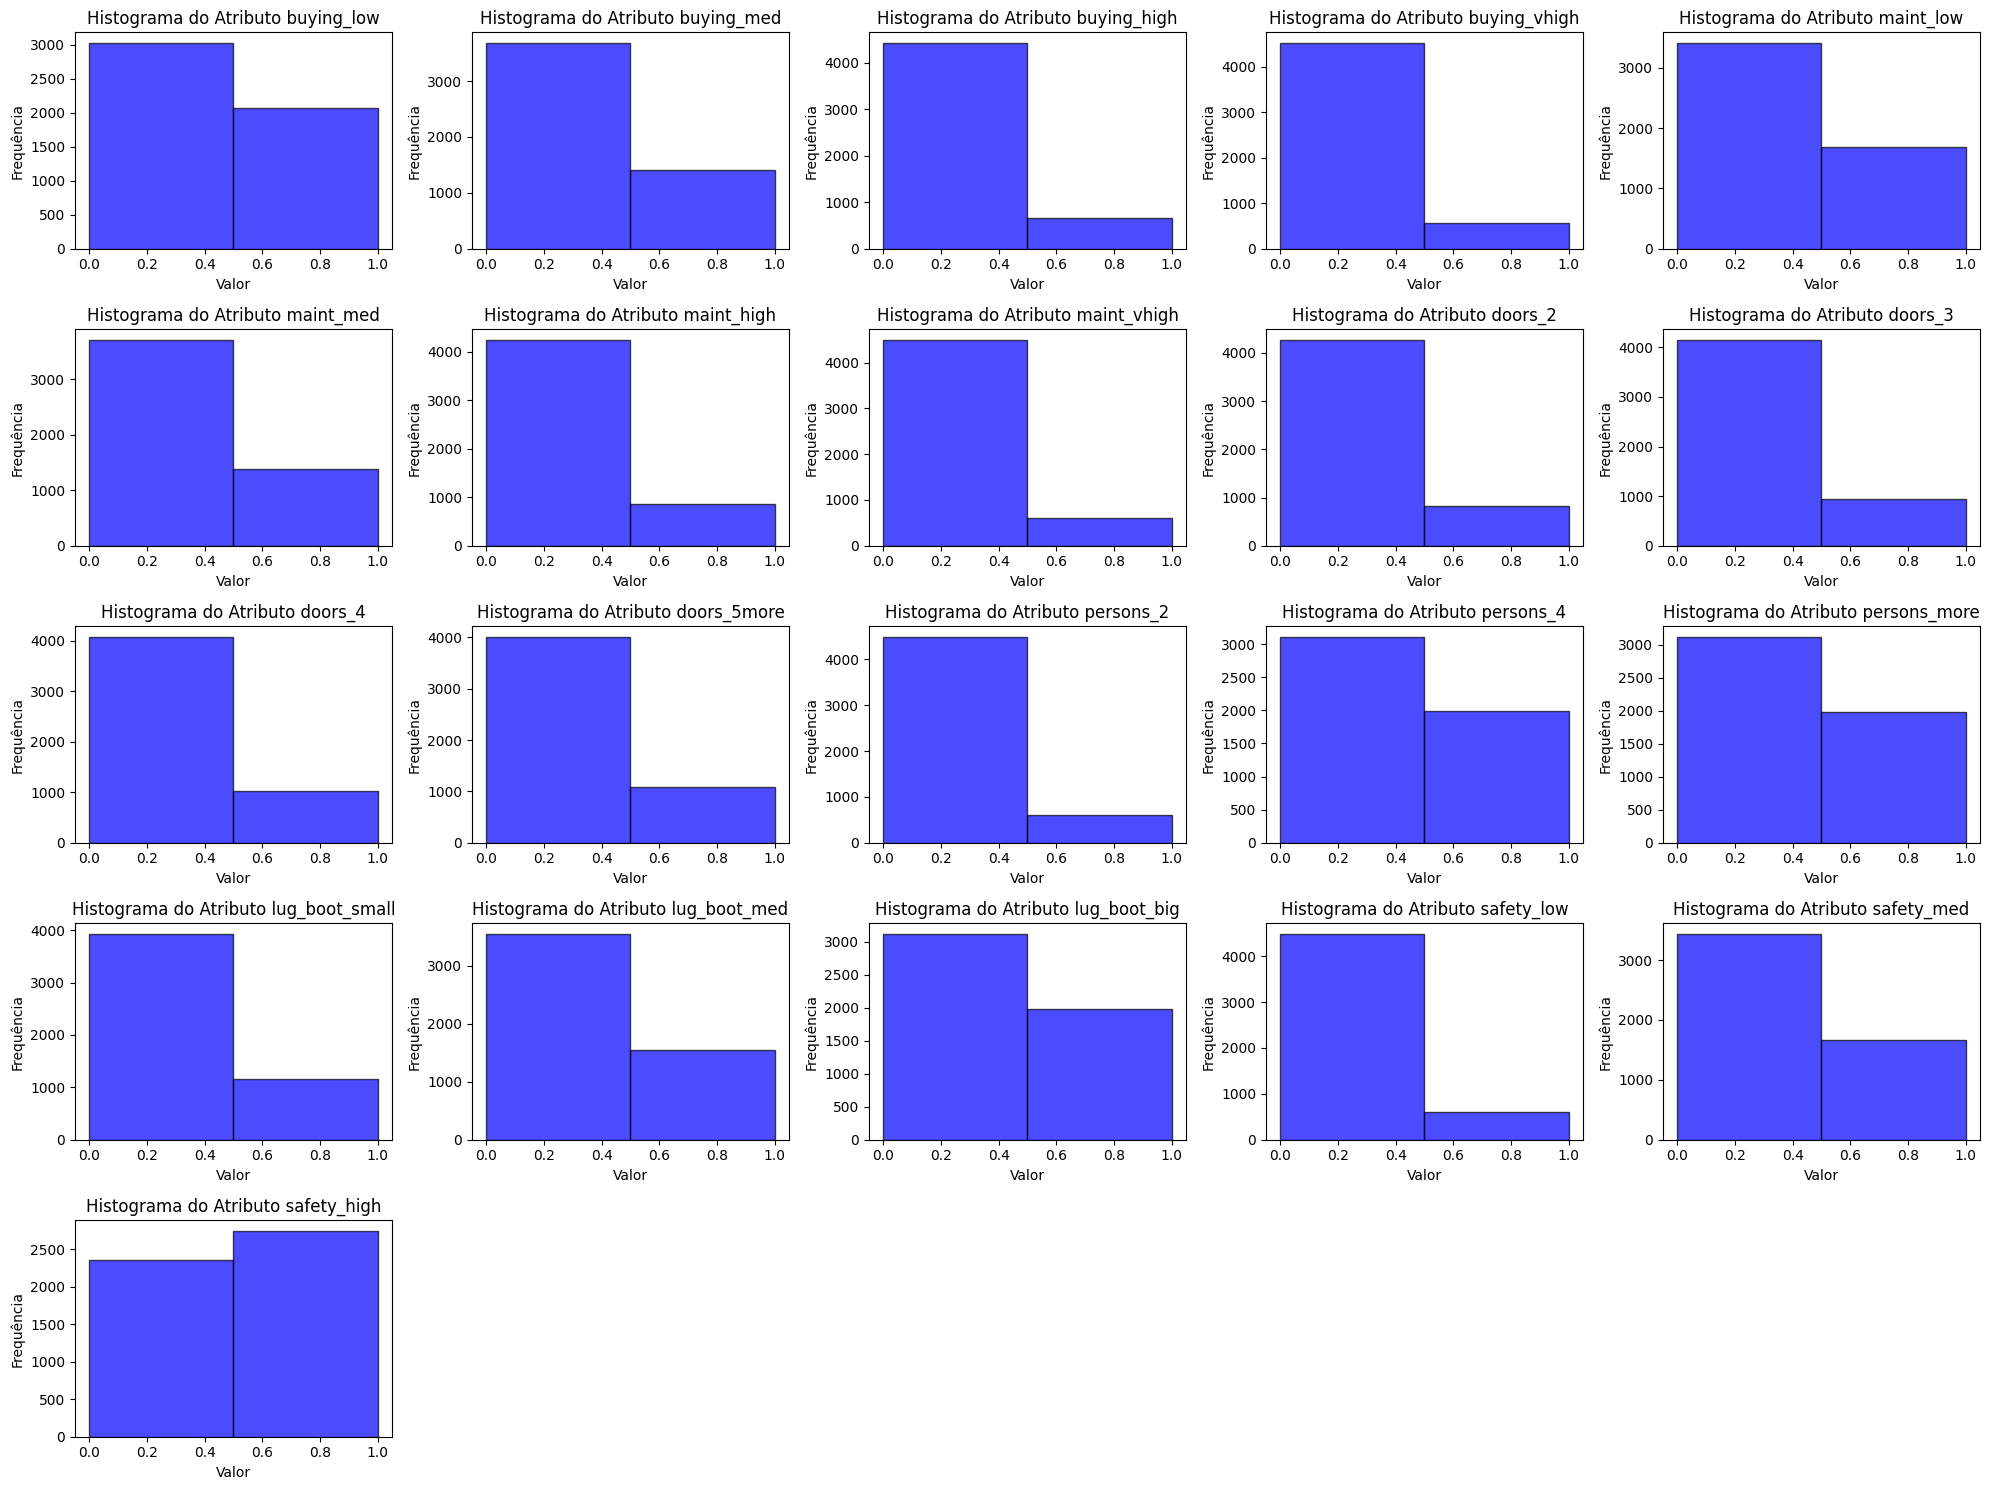

In [54]:
# Selecionando os atributos para visualização
attributes = [
    'buying_low', 'buying_med', 'buying_high', 'buying_vhigh', 
    'maint_low', 'maint_med', 'maint_high', 'maint_vhigh', 
    'doors_2', 'doors_3', 'doors_4', 'doors_5more', 
    'persons_2', 'persons_4', 'persons_more', 
    'lug_boot_small', 'lug_boot_med', 'lug_boot_big', 
    'safety_low', 'safety_med', 'safety_high'
]

# Configurando o tamanho da figura
plt.figure(figsize=(20, 15))

# Loop para criar histogramas para cada atributo
for i, attr in enumerate(attributes, start=1):
    plt.subplot(5, 5, i)  # Organiza os subgráficos em uma grade
    plt.hist(df_cleaned[attr], bins=2, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histograma do Atributo {attr}')
    plt.xlabel('Valor')
    plt.ylabel('Frequência')

plt.tight_layout()  # Ajusta os subgráficos para evitar sobreposição
plt.show()

### Matriz de Dispersão

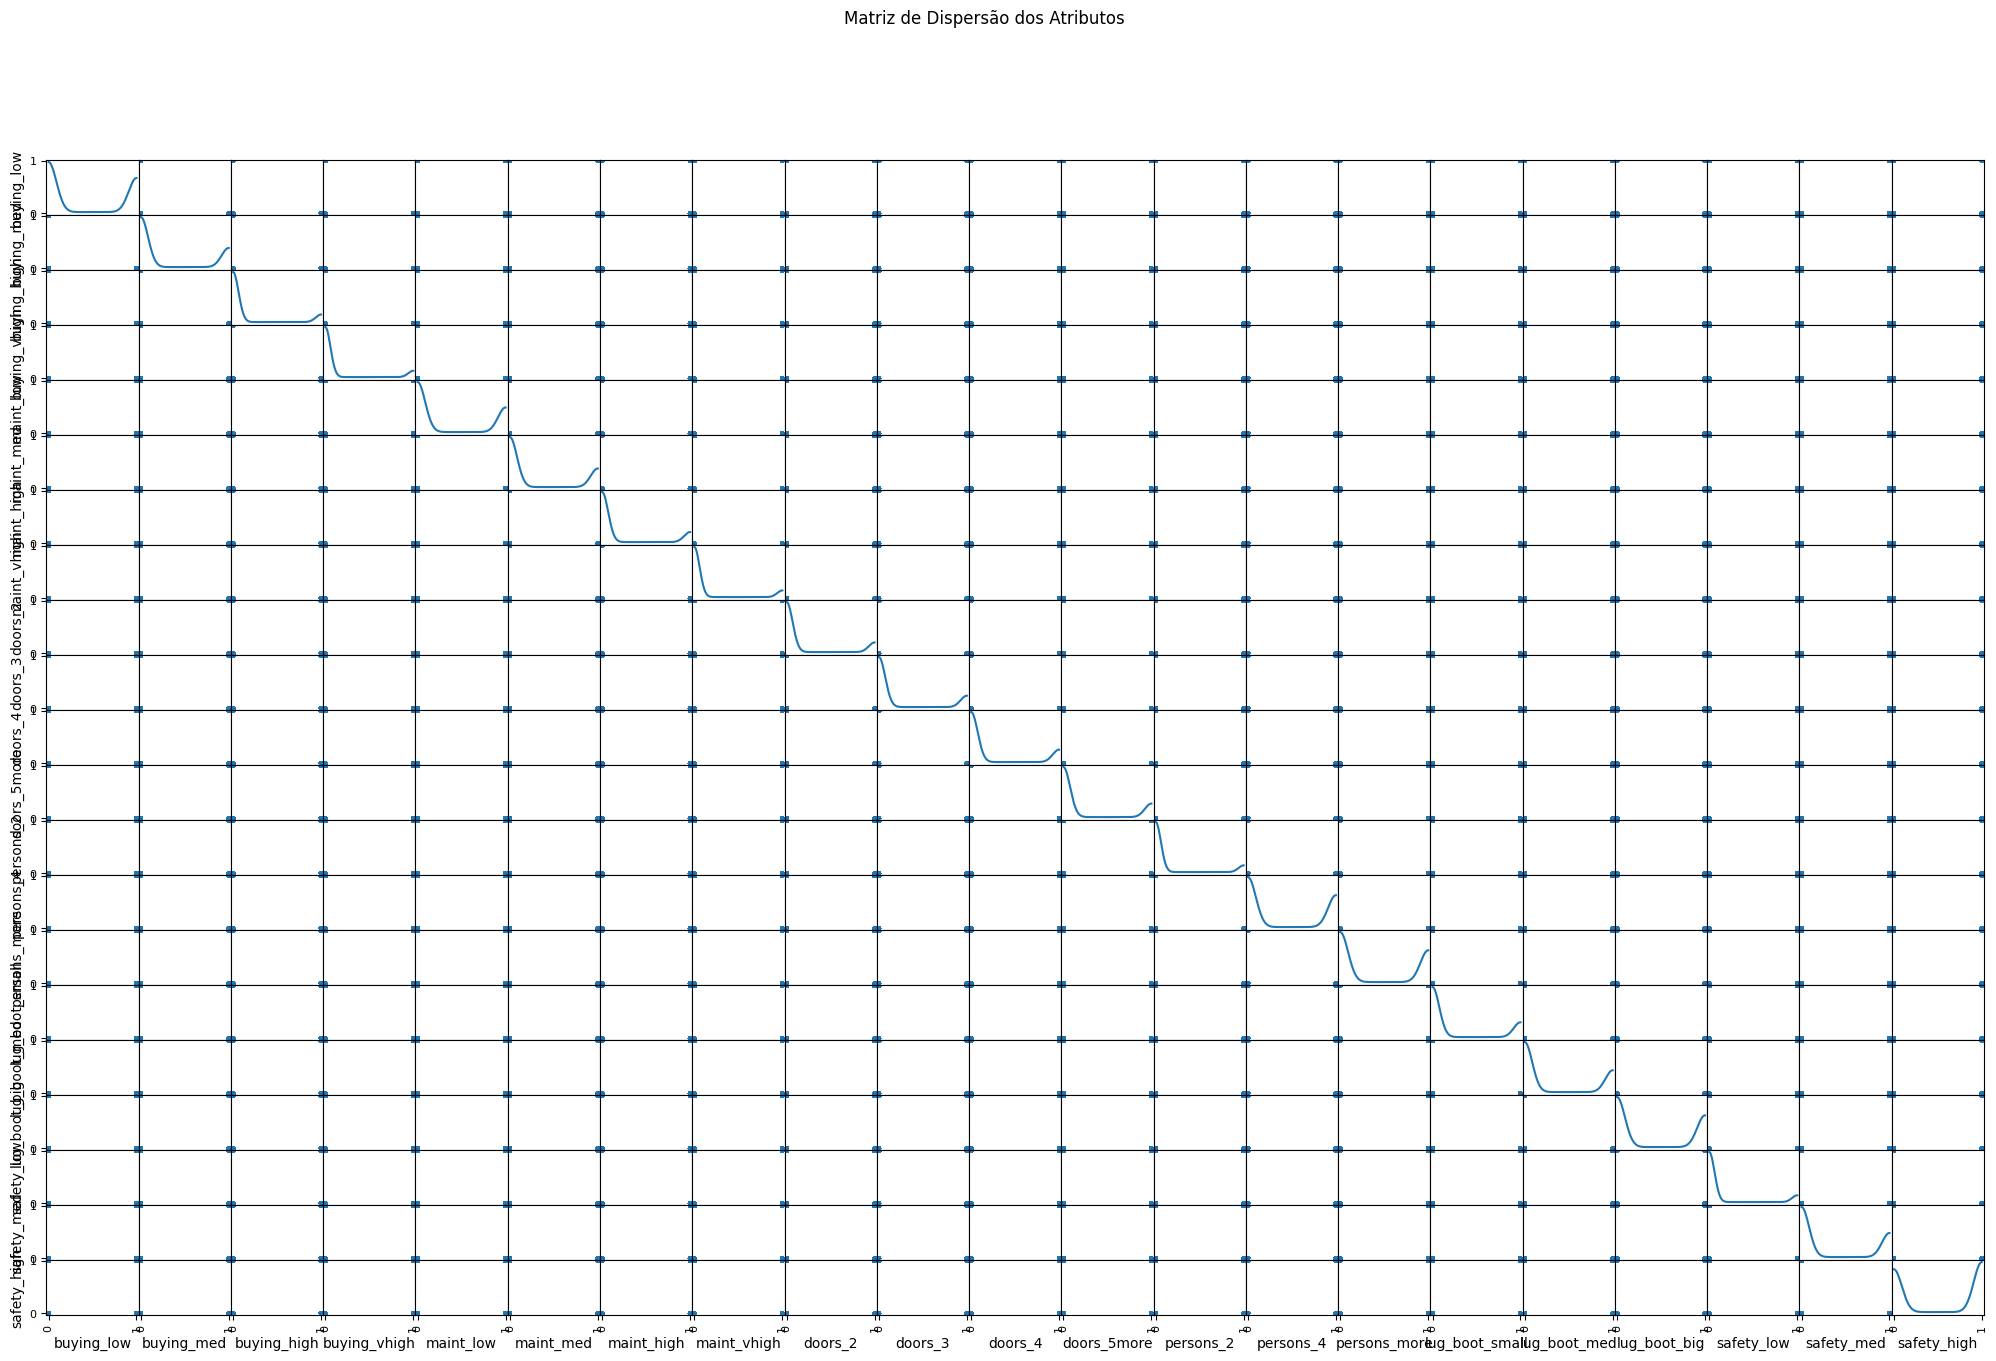

In [55]:
# Selecionando os atributos para a matriz de dispersão
attributes = [
    'buying_low', 'buying_med', 'buying_high', 'buying_vhigh', 
    'maint_low', 'maint_med', 'maint_high', 'maint_vhigh', 
    'doors_2', 'doors_3', 'doors_4', 'doors_5more', 
    'persons_2', 'persons_4', 'persons_more', 
    'lug_boot_small', 'lug_boot_med', 'lug_boot_big', 
    'safety_low', 'safety_med', 'safety_high'
]

# Criando a matriz de dispersão
scatter_matrix(df_cleaned[attributes], figsize=(25, 15), diagonal='kde', alpha=0.5)

plt.suptitle('Matriz de Dispersão dos Atributos')
plt.show()

### Heatmap de Correlação

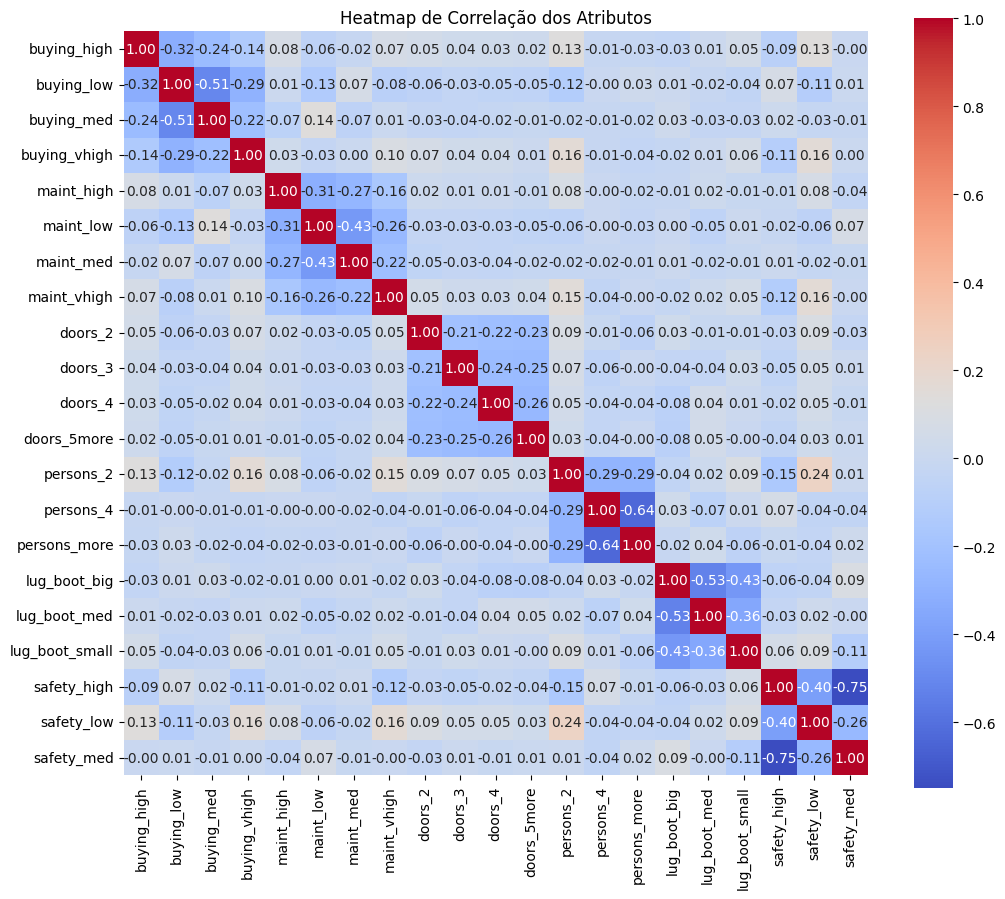

In [56]:
# Filtrando colunas numéricas e calculando a matriz de correlação
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_cleaned[numeric_columns].corr()

# Criando o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title('Heatmap de Correlação dos Atributos')
plt.show()
